# 0 - TODO
- regularization sur nos données (selection des tournois qui ont un impact sur le temps joué)
- dédoubler les lignes directement depuis le dataframe player / opponent
- % win player vs % win opponent
- continuer à faire des variables dynamiques
- variables dynamiques ne prennent pas en compte le résultat du match considéré
- arbres de décision (random forest etc...)
- dictionnaire des colonnes
- Prédire les matches qui durent plus de 3h
- !!!!! __Séparer bo3 et bo5__

https://github.com/JeffSackmann/tennis_atp/issues/86  
these column names all pertain to the winning player ( prefix 'w_').  

winner_ht ... height (metres)  
w_svpt ... number of own serve points contested  
w_1stIn ... number of own first serves in  
w_1stWon ... number of own first serve points won  
w_2ndWon ... number of own second serve points won  
w_SvGms ... number of own service games played  
w_bpSaved ... number of break points against own serve saved  
w_bpFaced ... number of break points against own serve faced  

https://github.com/JeffSackmann/tennis_atp/issues/112  
R = Right hand  
L = Left hand  
U = Unknown hand  

https://github.com/JeffSackmann/tennis_atp/issues/49  
'G', 'M', 'A', 'D':  
G - Grand Slam  
M – Masters  
A – ATP (500 & 250)  
D – Davis Cup  
O – Olympics  

In [1]:
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

In [4]:
def perc_print(a, b):
    return round((a-b)/a*100)

# I - Importation et nettoyage des données

In [5]:
PATH = '/home/steve/Documents/ENSAE/Projet_ML_Tennis/Data/tennis_atp/'

In [6]:
data = pd.read_csv(PATH+'atp_matches_2010.csv')
for annee in range(2000, 2020):
    data = pd.concat([data, pd.read_csv(PATH+'atp_matches_'+str(annee)+'.csv')], axis=0, sort=False)

print('La base contient {} observations et {} attributs.'.format(data.shape[0], data.shape[1]))

La base contient 64694 observations et 49 attributs.


Les index sont mis à jour.

In [7]:
data.reset_index(inplace=True, drop=True)

Aperçu de la base de donnée.

In [8]:
data.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1,NaN,Andy Roddick,R,188.0,USA,27.348392,103429,NaN,NaN,Peter Luczak,R,183.0,AUS,30.346338,7-6(5) 6-2,3,R32,84.0,15.0,0.0,63.0,42.0,36.0,14.0,10.0,3.0,3.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,Carsten Ball,L,198.0,AUS,22.543463,104999,NaN,NaN,Mischa Zverev,L,190.0,GER,22.370979,7-5 6-1,3,R32,70.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,2.0,2.0,66.0,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,Richard Gasquet,R,185.0,FRA,23.548255,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,28.451745,6-3 4-6 6-4,3,R32,121.0,5.0,4.0,97.0,51.0,33.0,27.0,15.0,5.0,8.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0


Les modifications suivantes sont apportées :
- Transformation des dates au format `datetime`
- Création de la variable `year`
- Suppression des match de la Davis Cup
- Suppression des lignes ne contenant pas de durée du match _'minutes'_
- Suppression des doublons

In [9]:
nb_obs = data.shape[0]
data['tourney_date'] = pd.to_datetime(data['tourney_date'], yearfirst=True, format='%Y%m%d')
data['year'] = data['tourney_date'].apply(lambda x: x.year)
data = data[~data['tourney_name'].str.startswith('Davis Cup')].copy()
data.dropna(subset=['minutes'], inplace=True)
data.drop_duplicates(inplace=True)
print('{} observations supprimées ({}%).'.format(nb_obs - data.shape[0], perc_print(nb_obs, data.shape[0])))

11093 observations supprimées (17%).


Suppession des observations dont le score contient des caractères ASCII

In [10]:
def contains_ascii_letter(txt):
    gate = False
    for i in range(len(txt)):
        if txt[i] in string.ascii_letters:
            gate = True
            break
    return gate

In [11]:
nb_obs = data.shape[0]
get_ascii_letter = np.zeros(data.shape[0], dtype=bool)
get_ascii_letter = data['score'].apply(contains_ascii_letter)
data = data[~get_ascii_letter].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data.shape[0], perc_print(nb_obs, data.shape[0])))

1678 observations supprimées (3%).


Correction de certaines valeurs aberrantes (suite à des vérifications effectuées en lignes)

In [12]:
data.loc[data[(data['tourney_id']=='2017-0308')&(data['match_num']==297)].index[0], 'minutes'] = 98
data.loc[data[(data['tourney_id']=='2016-M001')&(data['match_num']==294)].index[0], 'minutes'] = 90

__COMMENTAIRE__

In [13]:
data_winner = data.copy()
data_loser = data.copy()
data_winner.rename({'winner_name':'player_name'}, inplace=True)
data_loser.rename({'loser_name':'player_name'}, inplace=True)
data_winner['win_lose'] = ['w' for i in range(len(data_winner))]
data_loser['win_lose'] = ['l' for i in range(len(data_loser))]
data_winner = data_winner.rename(columns=lambda x: re.sub('winner','player',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('^w_','player_',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('loser','opponent',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('^l_','opponent_',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('loser','player',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('^l_','player_',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('winner','opponent',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('^w_','opponent_',x))
data = pd.concat([data_winner, data_loser], axis=0, sort=False)
data.reset_index(inplace=True, drop=True)

# II - Un premier modèle de base

Nous commençons par construire un modèle qui nous servira de baseline pour juger de la qualité des modèles qui le suivront. La mesure de qualité du modèle choisi sera la Mean Squared Error (MSE).  
  
La plupart de nos variables sont des statistiques concernant directement le match et ne sont donc pas utilisable lors d'une prédiction. Ces variables demanderont d'être aggrégés par la suite afin d'être utilisable pour caractériser un joueur.  
  
Ce modèle de base s'appuiera sur une régression linéaire, ce qui demande au préalable de transformer les variables catégorielles en dummies.

### 2.1 Mise en forme des données

In [164]:
X = data[['tourney_name', 'surface', 'tourney_level', 'player_hand', 'player_age', 'player_rank',
          'opponent_hand', 'opponent_age', 'opponent_rank', 'best_of', 'round', 'year']].copy()
y = data['minutes']

X.shape, y.shape

((103846, 12), (103846,))

On commence par retirer les lignes contenant des valeurs manquantes (non prises en charge par les algorithmes de régressions linéaires)

In [165]:
for col in X.columns:
    print(col, X[col].isna().sum())

tourney_name 0
surface 0
tourney_level 0
player_hand 0
player_age 0
player_rank 150
opponent_hand 0
opponent_age 0
opponent_rank 150
best_of 0
round 0
year 0


In [166]:
X.dropna(axis=0, how='any', inplace=True)
y = y[X.index]
X.shape, y.shape

((103546, 12), (103546,))

### One Hot Encoding des variables catégorielles

Nous observons le nombre de modalitées prises par les variables catégorielles traités

In [167]:
X_qual = ['tourney_name', 'surface', 'tourney_level', 'round', 'player_hand', 'opponent_hand']

In [168]:
for variable in X_qual:
    print(variable, ':', pd.get_dummies(X[variable]).shape[1])

tourney_name : 126
surface : 4
tourney_level : 4
round : 10
player_hand : 3
opponent_hand : 3


La variable `tourney_name` prend 133 modalités. La matrice étant trop sparse nous l'ignorons pour le moment.  
Les autres variables qualitatives seront retraitées de manière à ce que chaque modalité soit encodée par une dummy, en prenant garde au problème de multicolinéarité en utilisant l'option `drop_first=True` de la fonction `get_dummies`.

In [169]:
X_qual.remove('tourney_name')
X.drop(columns='tourney_name', inplace=True)

In [170]:
for variable in X_qual:
    var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
    X.drop(variable, axis=1, inplace=True)
    for col_enc in var_enc.columns:
        X[col_enc] = var_enc[col_enc]

### 2.2 Régression linéaire

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Nous utilisons finalement la fonction `LinearRegression` en notant que l'intercept est mise par défaut par la fonction (et la gestion de la multicolinéarité est égaelement gérée par défaut par la fonction) 

In [184]:
regLM = LinearRegression().fit(X.values, y.values)

In [188]:
y_pred = regLM.predict(X.values)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', regLM.score(X.values, y.values))

MSE : 1103.6152518740207 
Rsquared : 0.2811864380068887


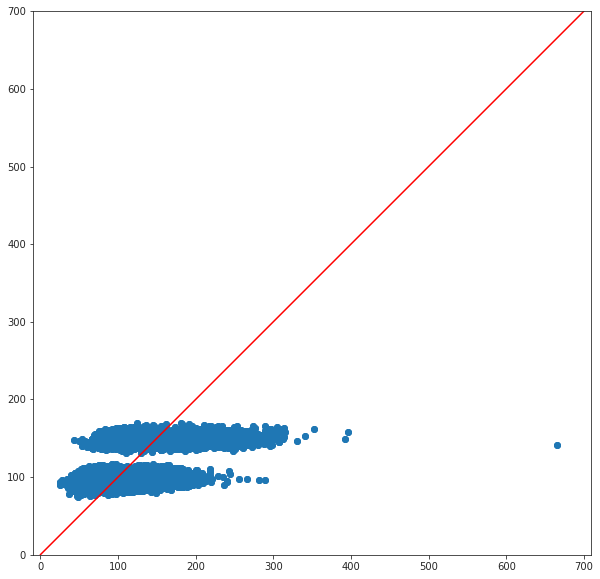

In [186]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()

### 2.2 Régression Lasso (Least Absolute Shrinkage and Selection Operator)

Afin de réaliser une sélection parcimonieuse de nos variables, nous effectuons une régression Lasso, qui, contrairement à la régression Ridge, permet d'assigner la valeur des coefficients exactement à zéro, et ainsi éliminer les variables non pertinentes.

In [291]:
from sklearn.linear_model import Lasso

In [292]:
regLasso = Lasso(alpha=1.0).fit(X.values, y.values)

In [293]:
y_pred = regLasso.predict(X.values)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', regLasso.score(X.values, y.values))

MSE : 1118.8533557596256 
Rsquared : 0.27126146124217554


Analyse des coefficients éliminés par la régularisation L1.

In [294]:
print('Coeffcients retenus :\n')
for var, coef in zip(X.columns, regLasso.coef_):
    if coefTrès sensible aux outliers! != 0:
        print('Coefficient {} = {}'.format(var, coef))
print('\nCoeffcients éliminés :\n')
for var, coef in zip(X.columns, regLasso.coef_):
    if coef == 0:
        print('Coefficient {} = {}'.format(var, coef))

Coeffcients retenus :

Coefficient player_rank = -0.014778453972829722
Coefficient opponent_rank = -0.014778471925517147
Coefficient best_of = 24.146540766652883
Coefficient year = 0.4289321155904257

Coeffcients éliminés :

Coefficient player_age = 0.0
Coefficient opponent_age = 0.0
Coefficient surface_Clay = 0.0
Coefficient surface_Grass = -0.0
Coefficient surface_Hard = -0.0
Coefficient tourney_level_F = 0.0
Coefficient tourney_level_G = 0.0
Coefficient tourney_level_M = 0.0
Coefficient round_ER = -0.0
Coefficient round_F = 0.0
Coefficient round_QF = 0.0
Coefficient round_R128 = 0.0
Coefficient round_R16 = 0.0
Coefficient round_R32 = -0.0
Coefficient round_R64 = -0.0
Coefficient round_RR = 0.0
Coefficient round_SF = 0.0
Coefficient player_hand_R = 0.0
Coefficient player_hand_U = -0.0
Coefficient opponent_hand_R = 0.0
Coefficient opponent_hand_U = -0.0


Un trop grand nombre d'attributs étant éliminé, nous réduisons le coefficient de pénalité $\alpha$ à 0.5.

In [317]:
regLasso = Lasso(alpha=0.5).fit(X.values, y.values)
y_pred = regLasso.predict(X.values)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', regLasso.score(X.values, y.values))
print('\n\nCoeffcients retenus :\n')
for var, coef in zip(X.columns, regLasso.coef_):
    if coef != 0:
        print('Coefficient {} = {}'.format(var, coef))
print('\nCoeffcients éliminés :\n')
for var, coef in zip(X.columns, regLasso.coef_):
    if coef == 0:
        print('Coefficient {} = {}'.format(var, coef))

MSE : 1114.3898254487692 
Rsquared : 0.27416867561454195


Coeffcients retenus :

Coefficient player_age = 0.033284645004187936
Coefficient player_rank = -0.014642652981431017
Coefficient opponent_age = 0.03336200596534734
Coefficient opponent_rank = -0.014642621593906295
Coefficient best_of = 25.076660347630618
Coefficient year = 0.4334823264556498
Coefficient surface_Clay = 1.9391453260222682
Coefficient surface_Grass = -0.21914485470487835

Coeffcients éliminés :

Coefficient surface_Hard = 0.0
Coefficient tourney_level_F = 0.0
Coefficient tourney_level_G = 0.0
Coefficient tourney_level_M = 0.0
Coefficient round_ER = -0.0
Coefficient round_F = 0.0
Coefficient round_QF = 0.0
Coefficient round_R128 = -0.0
Coefficient round_R16 = 0.0
Coefficient round_R32 = -0.0
Coefficient round_R64 = -0.0
Coefficient round_RR = 0.0
Coefficient round_SF = 0.0
Coefficient player_hand_R = 0.0
Coefficient player_hand_U = -0.0
Coefficient opponent_hand_R = 0.0
Coefficient opponent_hand_U = -0.0


### 2.3 Régression polynomial

Attention : Très sensible aux outliers!

In [313]:
from sklearn.preprocessing import PolynomialFeatures 

In [314]:
X_poly = PolynomialFeatures(degree = 2).fit_transform(X)
regPoly = LinearRegression().fit(X_poly, y.values)

In [315]:
y_pred = regPoly.predict(X_poly)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', regPoly.score(X_poly, y.values))

MSE : 1094.528684285455 
Rsquared : 0.28710475782309


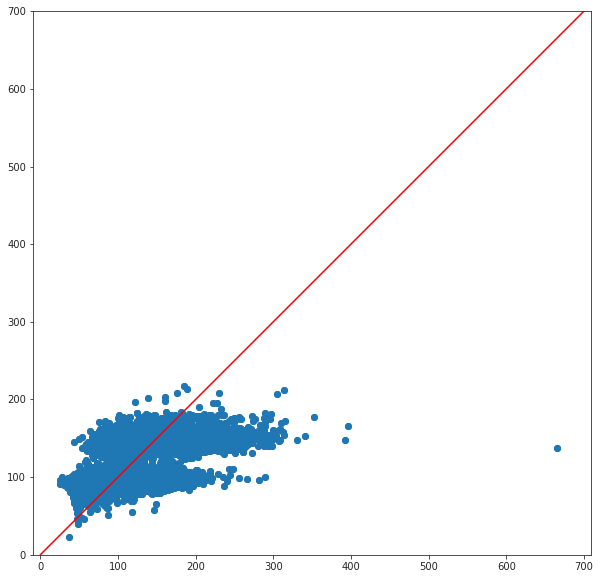

In [316]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()

### 2.4 Arbre de décision

In [198]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz

In [194]:
regTree = DecisionTreeRegressor(criterion='mse',
                                max_depth=5,
                                min_samples_leaf=10,
                                random_state=0
                               ).fit(X, y)

In [195]:
y_pred = regTree.predict(X.values)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', regTree.score(X.values, y.values))

MSE : 1103.1501654577933 
Rsquared : 0.28148936098925537


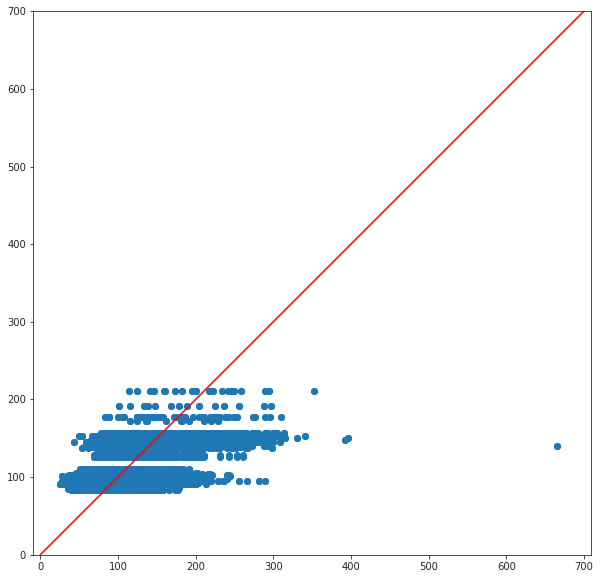

In [193]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()

On affiche ce première arbre simple d'une profondeur de 5. (Cliquez sur l'image pour l'agrandir)

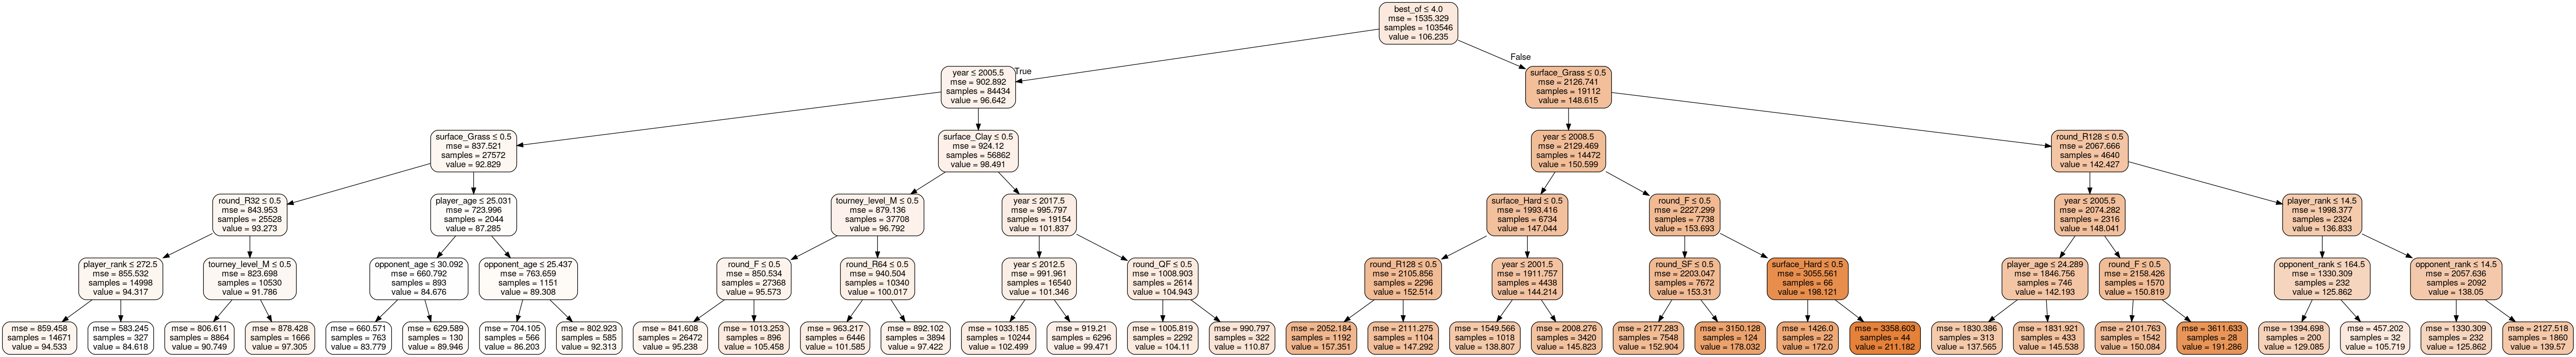

In [262]:
from IPython.display import Image
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()

export_graphviz(regTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 2.3 Régression linéaire de `statsmodels`

A l'aide de `statsmodels` qui nous donne le Adj. R-squared qui nous sera utile suite à l'ajout de la variable `tourney_name`. Il faut cependant cette fois-ci introduire une constante dans notre modèle avec la fonction `add_constant` car la fonction `ols` n'en utilise pas par défaut.

In [24]:
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
modele = ols('minutes ~ const + C(tourney_name) + C(surface) + C(tourney_level) + C(player_hand)+ player_age + player_rank\
          + C(opponent_hand) + opponent_age + opponent_rank + best_of + C(round) + year', data=add_constant(data))
resultat = modele.fit()

In [25]:
print('MSE :', resultat.mse_resid,
      '\nRsquared :', resultat.rsquared,
      '\nAdjusted Rsquared :', resultat.rsquared_adj)

MSE : 1099.9642446949726 
Rsquared : 0.28458844788151627 
Adjusted Rsquared : 0.28357135375821196


In [26]:
data.groupby('best_of')['minutes'].mean()

best_of
3     96.587680
5    148.604284
Name: minutes, dtype: float64

# III - Création de variables relatives à la rencontre

Les attributs présents dans notre base sont les suivantes.

In [27]:
print('Features de base :')
print(data.columns.values)

Features de base :
['tourney_id' 'tourney_name' 'surface' 'draw_size' 'tourney_level'
 'tourney_date' 'match_num' 'player_id' 'player_seed' 'player_entry'
 'player_name' 'player_hand' 'player_ht' 'player_ioc' 'player_age'
 'opponent_id' 'opponent_seed' 'opponent_entry' 'opponent_name'
 'opponent_hand' 'opponent_ht' 'opponent_ioc' 'opponent_age' 'score'
 'best_of' 'round' 'minutes' 'player_ace' 'player_df' 'player_svpt'
 'player_1stIn' 'player_1stWon' 'player_2ndWon' 'player_SvGms'
 'player_bpSaved' 'player_bpFaced' 'opponent_ace' 'opponent_df'
 'opponent_svpt' 'opponent_1stIn' 'opponent_1stWon' 'opponent_2ndWon'
 'opponent_SvGms' 'opponent_bpSaved' 'opponent_bpFaced' 'player_rank'
 'player_rank_points' 'opponent_rank' 'opponent_rank_points' 'year'
 'win_lose']


A partir de ces données initiales, nous allons créer de nouvelles features dans le but de maximiser le signal inclu dans nos attributs. 

### 3.1 Ecart de classement entre les deux joueurs

In [28]:
data['diff_ranking'] = data.apply(lambda x: abs(x.player_rank - x.opponent_rank), axis=1)
data['diff_ranking'].head(3)

0    70.0
1    56.0
2    36.0
Name: diff_ranking, dtype: float64

### 3.2 Classement moyen des deux joueurs du match

In [29]:
data['avg_ranking'] = data.apply(lambda x: (x.player_rank + x.opponent_rank)/2, axis=1)
data['avg_ranking'].head(3)

0     42.0
1    106.0
2     70.0
Name: avg_ranking, dtype: float64

### 3.3 Les joueurs jouent de la même main

In [30]:
data['same_hand'] = data.apply(lambda x: 1 if x['player_hand']!=x['opponent_hand'] else 0, axis=1)
data['same_hand'].head(3)

0    0
1    0
2    1
Name: same_hand, dtype: int64

# IV - Création de variables caractéristiques du joueur 

Dans cette partie nous devons isoler les matchs joués par chacun des joueurs présents dans notre base pour créer des features différentes en fonction du joueur

In [31]:
nb_joueur = data['player_name'].unique().shape[0]
print('Nombre de joueur différents dans notre base :', nb_joueur)

Nombre de joueur différents dans notre base : 1355


Nous distinguons à partir d'ici les observations relatives à des Bo3 / Bo5. __EXPLIQUER POURQUOI__

In [32]:
data_bo5 = data[data['best_of']==5].copy()
data_bo3 = data[data['best_of']==3].copy()

data_bo5.shape[0] + data_bo3.shape[0] == data.shape[0]

True

### 4.1 Temps de match moyen d'un joueur

In [33]:
mean_time = data_bo3.groupby(['player_name'])['minutes'].mean()
data_bo3['player_mean_time'] = np.zeros(data_bo3.shape[0])
data_bo3['player_mean_time'] = data_bo3.apply(lambda x: mean_time[x['player_name']], axis=1)
data_bo3[['player_name', 'player_mean_time']].head(3)

,player_name,player_mean_time
0,Andy Roddick,90.101201
1,Carsten Ball,83.375000
2,Richard Gasquet,95.785256


In [34]:
mean_time = data_bo5.groupby(['player_name'])['minutes'].mean()
data_bo5['player_mean_time'] = np.zeros(data_bo5.shape[0])
data_bo5['player_mean_time'] = data_bo5.apply(lambda x: mean_time[x['player_name']], axis=1)
data_bo5[['player_name', 'player_mean_time']].head(3)

,player_name,player_mean_time
143,Roger Federer,131.043165
144,Victor Hanescu,144.343750
145,Stephane Robert,130.333333


### 4.2 Temps moyen des 10 derniers matchs d'un joueur

Cette opération étant amenée à être répétée, dans le but de rendre le code moins redondant nous créons une fonction qui nous permet de faire des variables représentant la dynamique d'un joueur.  
  
__Décrire cette fonction__

In [35]:
def dynamic_features(df, target_feature, new_feature_name, list_sort_features, window_size=10):
    # player
    player_new_feature_name = 'player_' + new_feature_name
    df[player_new_feature_name] = np.zeros(df.shape[0])
    df = df.sort_values(['player_name']+list_sort_features).copy()
    df[player_new_feature_name] = df.sort_values(['player_name']+list_sort_features).groupby('player_name')[target_feature].rolling(window=window_size,min_periods=1).mean().values
    df[player_new_feature_name+'_shifted'] = df.sort_values(['player_name']+list_sort_features).groupby('player_name')[player_new_feature_name].shift(1).values
    df.sort_values(['player_name']+list_sort_features, inplace=True)
    print(df[df['player_name']=='Roger Federer'][['player_name', target_feature, player_new_feature_name, player_new_feature_name+'_shifted']].head(5))
    print('\n')
    # opponent
    opponent_new_feature_name = 'opponent_' + new_feature_name
    df[opponent_new_feature_name] = np.zeros(df.shape[0])
    df = df.sort_values(['opponent_name']+list_sort_features).copy()
    df[opponent_new_feature_name] = df.sort_values(list_sort_features).groupby('opponent_name')[target_feature].rolling(window=window_size,min_periods=1).mean().values
    df[opponent_new_feature_name+'_shifted'] = df.sort_values(['opponent_name']+list_sort_features).groupby('opponent_name')[opponent_new_feature_name].shift(1).values
    df.sort_values(['opponent_name']+list_sort_features, inplace=True)
    print(df[df['opponent_name']=='Roger Federer'][['opponent_name', target_feature, opponent_new_feature_name, opponent_new_feature_name+'_shifted']].head(5))
    return df.copy()

Nous appliquons cette fonction ...

In [36]:
data_bo3 = dynamic_features(df=data_bo3, target_feature='minutes', new_feature_name='mean_10time', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  minutes  player_mean_10time  player_mean_10time_shifted
3154   Roger Federer     45.0           45.000000                         NaN
55092  Roger Federer     84.0           64.500000                   45.000000
54518  Roger Federer     68.0           65.666667                   64.500000
4523   Roger Federer     72.0           67.250000                   65.666667
4537   Roger Federer     63.0           66.400000                   67.250000


       opponent_name  minutes  opponent_mean_10time  \
55077  Roger Federer     45.0             45.000000   
3169   Roger Federer     84.0             64.500000   
2595   Roger Federer     68.0             65.666667   
56446  Roger Federer     72.0             67.250000   
56460  Roger Federer     63.0             66.400000   

       opponent_mean_10time_shifted  
55077                           NaN  
3169                      45.000000  
2595                      64.500000  
56446                     65.666667  
56460    

In [37]:
data_bo5 = dynamic_features(df=data_bo5, target_feature='minutes', new_feature_name='mean_10time', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  minutes  player_mean_10time  player_mean_10time_shifted
5121   Roger Federer    125.0          125.000000                         NaN
5157   Roger Federer    106.0          115.500000                  125.000000
57099  Roger Federer    101.0          110.666667                  115.500000
4689   Roger Federer    147.0          119.750000                  110.666667
4725   Roger Federer    132.0          122.200000                  119.750000


       opponent_name  minutes  opponent_mean_10time  \
57044  Roger Federer    125.0            125.000000   
57080  Roger Federer    106.0            115.500000   
5176   Roger Federer    101.0            110.666667   
56612  Roger Federer    147.0            119.750000   
56648  Roger Federer    132.0            122.200000   

       opponent_mean_10time_shifted  
57044                           NaN  
57080                    125.000000  
5176                     115.500000  
56612                    110.666667  
56648    

<font color='green'>__Vérification__</font>

In [39]:
data_bo3.sort_values(['player_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo3[data_bo3['player_name']=='Roger Federer'][['player_name', 'minutes', 'player_mean_10time', 'player_mean_10time_shifted']].head(5))

         player_name  minutes  player_mean_10time  player_mean_10time_shifted
3154   Roger Federer     45.0           45.000000                         NaN
55092  Roger Federer     84.0           64.500000                   45.000000
54518  Roger Federer     68.0           65.666667                   64.500000
4523   Roger Federer     72.0           67.250000                   65.666667
4537   Roger Federer     63.0           66.400000                   67.250000


In [40]:
data_bo5.sort_values(['player_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo5[data_bo5['player_name']=='Roger Federer'][['player_name', 'minutes', 'player_mean_10time', 'player_mean_10time_shifted']].head(5))

         player_name  minutes  player_mean_10time  player_mean_10time_shifted
5121   Roger Federer    125.0          125.000000                         NaN
5157   Roger Federer    106.0          115.500000                  125.000000
57099  Roger Federer    101.0          110.666667                  115.500000
4689   Roger Federer    147.0          119.750000                  110.666667
4725   Roger Federer    132.0          122.200000                  119.750000


In [41]:
data_bo3.sort_values(['opponent_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo3[data_bo3['opponent_name']=='Roger Federer'][['opponent_name', 'minutes', 'opponent_mean_10time', 'opponent_mean_10time_shifted']].head(5))

       opponent_name  minutes  opponent_mean_10time  \
55077  Roger Federer     45.0             45.000000   
3169   Roger Federer     84.0             64.500000   
2595   Roger Federer     68.0             65.666667   
56446  Roger Federer     72.0             67.250000   
56460  Roger Federer     63.0             66.400000   

       opponent_mean_10time_shifted  
55077                           NaN  
3169                      45.000000  
2595                      64.500000  
56446                     65.666667  
56460                     67.250000  


In [42]:
data_bo5.sort_values(['opponent_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo5[data_bo5['opponent_name']=='Roger Federer'][['opponent_name', 'minutes', 'opponent_mean_10time', 'opponent_mean_10time_shifted']].head(5))

       opponent_name  minutes  opponent_mean_10time  \
57044  Roger Federer    125.0            125.000000   
57080  Roger Federer    106.0            115.500000   
5176   Roger Federer    101.0            110.666667   
56612  Roger Federer    147.0            119.750000   
56648  Roger Federer    132.0            122.200000   

       opponent_mean_10time_shifted  
57044                           NaN  
57080                    125.000000  
5176                     115.500000  
56612                    110.666667  
56648                    119.750000  


On supprime les première observations contenant

### 4.3 Nombre de sets moyen joué par un joueur

Nous commencons par extraire le nombre de set joué dans chaque match

In [43]:
data_bo3['nb_games'] = data_bo3.apply(lambda x: x['score'].split(' '), axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: [string.split('-') for string in x['nb_games']], axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: [[int(elt[0]) for elt in liste if len(elt)>0] for liste in x['nb_games']], axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: [sum(liste) for liste in x['nb_games']], axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: sum(x['nb_games']), axis=1)

In [44]:
data_bo5['nb_games'] = data_bo5.apply(lambda x: x['score'].split(' '), axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: [string.split('-') for string in x['nb_games']], axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: [[int(elt[0]) for elt in liste if len(elt)>0] for liste in x['nb_games']], axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: [sum(liste) for liste in x['nb_games']], axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: sum(x['nb_games']), axis=1)

In [45]:
data_bo3['nb_games'].unique()

array([14, 15, 13, 28, 19, 21, 24, 17, 18, 34, 16, 27, 32, 22, 20, 25, 23,
       26, 30, 31, 36, 35, 33, 29, 39, 38, 12, 37, 10, 11])

In [46]:
data_bo5['nb_games'].unique()

array([41, 28, 37, 36, 23, 32, 22, 26, 49, 29, 25, 53, 21, 50, 24, 30, 47,
       35, 46, 40, 27, 38, 31, 52, 43, 39, 48, 55, 51, 34, 33, 45, 42, 44,
       56, 59, 20, 54, 60, 19, 57, 66, 61, 58, 64, 65, 62, 15, 63])

Un match de tennis fait au minimum 12 jeux, l'analyse du nombre de set joué dans nos donnée nous indique que certaines rencontrent finissent après 10 et 11 jeux. Nous supprimons ces matchs car ils ne respectent pas ce seuil (l'abandon n'est pas notifié dans la base).

In [47]:
nb_obs = data_bo3.shape[0]
data_bo3 = data_bo3[data_bo3['nb_games']>=12].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo3.shape[0], perc_print(nb_obs, data_bo3.shape[0])))

6 observations supprimées (0%).


In [48]:
nb_obs = data_bo5.shape[0]
data_bo5 = data_bo5[data_bo5['nb_games']>=18].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo5.shape[0], perc_print(nb_obs, data_bo5.shape[0])))

2 observations supprimées (0%).


Une fois le nombre de jeux d'une rencontre disponible dans notre base, nous déterminons le nombre de sets joué en moyenne pour chaque joueur ainsi que son advsersaire.

In [49]:
data_bo3['player_mean_games'] = np.zeros(data_bo3.shape[0])
for player in data_bo3['player_name'].unique():
    player_mean_games = data_bo3[data_bo3['player_name']==player]['nb_games'].mean()
    data_bo3['player_mean_games'].loc[data_bo3[data_bo3['player_name']==player].index] = player_mean_games.copy()

/home/steve/anaconda3/envs/projetML/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [50]:
data_bo5['player_mean_games'] = np.zeros(data_bo5.shape[0])
for player in data_bo5['player_name'].unique():
    player_mean_games = data_bo5[data_bo5['player_name']==player]['nb_games'].mean()
    data_bo5['player_mean_games'].loc[data_bo5[data_bo5['player_name']==player].index] = player_mean_games.copy()

In [51]:
data_bo3['player_mean_games'].describe()

count    84700.000000
mean        23.022597
std          1.081867
min         12.000000
25%         22.536082
50%         22.992000
75%         23.537634
max         38.000000
Name: player_mean_games, dtype: float64

In [52]:
data_bo5['player_mean_games'].describe()

count    19138.000000
mean        35.962274
std          2.159375
min         21.000000
25%         34.716216
50%         36.053691
75%         37.240000
max         56.000000
Name: player_mean_games, dtype: float64

### 4.4 Nombre de sets moyen d'un joueur sur ses 10 derniers matchs

#### 4.4.1 Player

In [53]:
data_bo3 = dynamic_features(df=data_bo3, target_feature='nb_games', new_feature_name='mean_10games', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  nb_games  player_mean_10games  \
3154   Roger Federer        17                 17.0   
55092  Roger Federer        23                 20.0   
54518  Roger Federer        20                 20.0   
4523   Roger Federer        20                 20.0   
4537   Roger Federer        17                 19.4   

       player_mean_10games_shifted  
3154                           NaN  
55092                         17.0  
54518                         20.0  
4523                          20.0  
4537                          20.0  


       opponent_name  nb_games  opponent_mean_10games  \
55077  Roger Federer        17                   17.0   
3169   Roger Federer        23                   20.0   
2595   Roger Federer        20                   20.0   
56446  Roger Federer        20                   20.0   
56460  Roger Federer        17                   19.4   

       opponent_mean_10games_shifted  
55077                            NaN  
3169                    

In [54]:
data_bo5 = dynamic_features(df=data_bo5, target_feature='nb_games', new_feature_name='mean_10games', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  nb_games  player_mean_10games  \
5121   Roger Federer        33            33.000000   
5157   Roger Federer        30            31.500000   
57099  Roger Federer        26            29.666667   
4689   Roger Federer        38            31.750000   
4725   Roger Federer        31            31.600000   

       player_mean_10games_shifted  
5121                           NaN  
5157                     33.000000  
57099                    31.500000  
4689                     29.666667  
4725                     31.750000  


       opponent_name  nb_games  opponent_mean_10games  \
57044  Roger Federer        33              33.000000   
57080  Roger Federer        30              31.500000   
5176   Roger Federer        26              29.666667   
56612  Roger Federer        38              31.750000   
56648  Roger Federer        31              31.600000   

       opponent_mean_10games_shifted  
57044                            NaN  
57080                   

<font color='green'>__Vérification__</font>

In [55]:
data_bo3.sort_values(['player_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo3[data_bo3['player_name']=='Roger Federer'][['player_name', 'nb_games', 'player_mean_10games', 'player_mean_10games_shifted']].head(5))

         player_name  nb_games  player_mean_10games  \
3154   Roger Federer        17                 17.0   
55092  Roger Federer        23                 20.0   
54518  Roger Federer        20                 20.0   
4523   Roger Federer        20                 20.0   
4537   Roger Federer        17                 19.4   

       player_mean_10games_shifted  
3154                           NaN  
55092                         17.0  
54518                         20.0  
4523                          20.0  
4537                          20.0  


In [56]:
data_bo5.sort_values(['player_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo5[data_bo5['player_name']=='Roger Federer'][['player_name', 'nb_games', 'player_mean_10games', 'player_mean_10games_shifted']].head(5))

         player_name  nb_games  player_mean_10games  \
5121   Roger Federer        33            33.000000   
5157   Roger Federer        30            31.500000   
57099  Roger Federer        26            29.666667   
4689   Roger Federer        38            31.750000   
4725   Roger Federer        31            31.600000   

       player_mean_10games_shifted  
5121                           NaN  
5157                     33.000000  
57099                    31.500000  
4689                     29.666667  
4725                     31.750000  


In [57]:
data_bo3.sort_values(['opponent_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo3[data_bo3['opponent_name']=='Roger Federer'][['opponent_name', 'nb_games', 'opponent_mean_10games', 'opponent_mean_10games_shifted']].head(5))

       opponent_name  nb_games  opponent_mean_10games  \
55077  Roger Federer        17                   17.0   
3169   Roger Federer        23                   20.0   
2595   Roger Federer        20                   20.0   
56446  Roger Federer        20                   20.0   
56460  Roger Federer        17                   19.4   

       opponent_mean_10games_shifted  
55077                            NaN  
3169                            17.0  
2595                            20.0  
56446                           20.0  
56460                           20.0  


In [58]:
data_bo5.sort_values(['opponent_name', 'tourney_date', 'match_num'], inplace=True)
print(data_bo5[data_bo5['opponent_name']=='Roger Federer'][['opponent_name', 'nb_games', 'opponent_mean_10games', 'opponent_mean_10games_shifted']].head(5))

       opponent_name  nb_games  opponent_mean_10games  \
57044  Roger Federer        33              33.000000   
57080  Roger Federer        30              31.500000   
5176   Roger Federer        26              29.666667   
56612  Roger Federer        38              31.750000   
56648  Roger Federer        31              31.600000   

       opponent_mean_10games_shifted  
57044                            NaN  
57080                      33.000000  
5176                       31.500000  
56612                      29.666667  
56648                      31.750000  


### 4.5 Suppression des lignes contenant les NA dûs au shift

In [59]:
nb_obs = data_bo3.shape[0]
data_bo3.dropna(subset=['player_mean_10games_shifted',
                    'opponent_mean_10games_shifted',
                    'player_mean_10time_shifted', 
                    'opponent_mean_10time_shifted'],
           axis=0,
           inplace=True)
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo3.shape[0], perc_print(nb_obs, data_bo3.shape[0])))

2478 observations supprimées (3%).


In [60]:
nb_obs = data_bo5.shape[0]
data_bo5.dropna(subset=['player_mean_10games_shifted',
                    'opponent_mean_10games_shifted',
                    'player_mean_10time_shifted', 
                    'opponent_mean_10time_shifted'],
           axis=0,
           inplace=True)
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo5.shape[0], perc_print(nb_obs, data_bo5.shape[0])))

1386 observations supprimées (7%).


On remarque que le nombre d'observations supprimées n'est pas égale au double du nombre de joueurs uniques présent dans nos données. Après vérification, ce résultat est dû aux matchs dans lesquels les deux joueurs apparaissent pour la première fois dans notre base de donnée (et donc leur _shiffted_value_ est égale à NaN pour les deux sur la même ligne).

### 4.6 Features de différences

In [61]:
data_bo3['diff_mean_10time_shifted'] = data_bo3.apply(lambda x: abs(x['player_mean_10time_shifted']-x['opponent_mean_10time_shifted']), axis=1)

In [62]:
data_bo5['diff_mean_10time_shifted'] = data_bo5.apply(lambda x: abs(x['player_mean_10time_shifted']-x['opponent_mean_10time_shifted']), axis=1)

In [63]:
data_bo3['diff_mean_10games_shifted'] = data_bo3.apply(lambda x: abs(x['player_mean_10games_shifted']-x['opponent_mean_10games_shifted']), axis=1)

In [64]:
data_bo5['diff_mean_10games_shifted'] = data_bo5.apply(lambda x: abs(x['player_mean_10games_shifted']-x['opponent_mean_10games_shifted']), axis=1)

# V - Création d'une clef synthétique pour pouvoir droper les duplicates (ne plus avoir les matchs en double)

In [66]:
data_bo3['synth_key'] = data_bo3.apply(lambda x: x['tourney_id']+'-'+str(x['match_num']), axis=1)
data_bo3[['tourney_id', 'match_num', 'synth_key']].head(1)
len_before = len(data_bo3)
data_bo3 = data_bo3.copy()
data_bo3.drop_duplicates('synth_key', keep='first', inplace=True)
len_after = len(data_bo32)
if len_before == 2 * len_after:
    print('Dédoublement réussi (avant {} - après {})'.format(len_before, len_after))
else:
    print('Erreur lors du dédoublement des observations (avant {} - après {})'.format(len_before, len_after))

Dédoublement réussi (avant 82222 - après 41111)


In [67]:
data_bo5['synth_key'] = data_bo5.apply(lambda x: x['tourney_id']+'-'+str(x['match_num']), axis=1)
data_bo5[['tourney_id', 'match_num', 'synth_key']].head(1)
len_before = len(data_bo5)
data_bo5 = data_bo5.copy()
data_bo5.drop_duplicates('synth_key', keep='first', inplace=True)
len_after = len(data_bo5)
if len_before == 2 * len_after:
    print('Dédoublement réussi (avant {} - après {})'.format(len_before, len_after))
else:
    print('Erreur lors du dédoublement des observations (avant {} - après {})'.format(len_before, len_after))

Dédoublement réussi (avant 17752 - après 8876)


# BROUILLON

In [ ]:
data['shifted_time'] = data.sort_values(['player_name',
                                               'tourney_date',
                                               'match_num']
                                             ).groupby('player_name')['minutes'].shift(1).values

In [ ]:
modele = ols('minutes ~ const + C(tourney_name) + C(surface) + C(tourney_level) +  player_age \
          + opponent_age + best_of + C(round) + year+  diff_ranking + avg_ranking + mean_time' , data=add_constant(data))
resultat = modele.fit()

In [ ]:
print('MSE :', resultat.mse_resid,
      '\nRsquared :', resultat.rsquared,
      '\nAdjusted Rsquared :', resultat.rsquared_adj)

In [ ]:
y_pred = resultat.fittedvalues

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()

In [101]:
X = data_bo3[['year', 'surface', 'round', 'diff_ranking', 'avg_ranking', 
                 'same_hand', 'diff_mean_10time_shifted', 'diff_mean_10games_shifted']].copy()

In [90]:
data_bo5.shape

(8876, 68)

In [102]:
X_qual = ['surface', 'round']

In [103]:
for variable in X_qual:
    var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=True)
    X.drop(variable, axis=1, inplace=True)
    for col_enc in var_enc.columns:
        X[col_enc] = var_enc[col_enc]

In [87]:
X.head()

,diff_ranking,avg_ranking,same_hand,diff_mean_10time_shifted,diff_mean_10games_shifted,surface_Clay,surface_Grass,surface_Hard,round_QF,round_R128,round_R16,round_R32,round_R64,round_SF
43020,100.0,82.0,0,29.800000,4.600000,1,0,0,0,0,0,0,1,0
97761,62.0,105.0,0,4.583333,0.166667,0,1,0,0,1,0,0,0,0
45869,132.0,70.0,0,31.050000,1.400000,0,1,0,0,0,0,0,1,0
99967,104.0,133.0,0,13.900000,4.000000,1,0,0,0,1,0,0,0,0
48101,173.0,98.5,0,24.200000,0.166667,1,0,0,0,0,0,0,1,0


In [93]:
X.reset_index(inplace=True, drop=True)

In [106]:
X.dropna(axis=0, how='any', inplace=True)
y = y[X.index]

X.shape, y.shape

((41033, 18), (41033,))

In [97]:
X.head()

,diff_ranking,avg_ranking,same_hand,diff_mean_10time_shifted,diff_mean_10games_shifted,surface_Clay,surface_Grass,surface_Hard,round_QF,round_R128,round_R16,round_R32,round_R64,round_SF
0,100.0,82.0,0,29.800000,4.600000,1,0,0,0,0,0,0,1,0
1,62.0,105.0,0,4.583333,0.166667,0,1,0,0,1,0,0,0,0
2,132.0,70.0,0,31.050000,1.400000,0,1,0,0,0,0,0,1,0
3,104.0,133.0,0,13.900000,4.000000,1,0,0,0,1,0,0,0,0
4,173.0,98.5,0,24.200000,0.166667,1,0,0,0,0,0,0,1,0


In [107]:
reg = LinearRegression().fit(X.values, y.values)

y_pred = reg.predict(X.values)
print('MSE :', mean_squared_error(y.values, y_pred),
      '\nRsquared :', reg.score(X.values, y.values))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

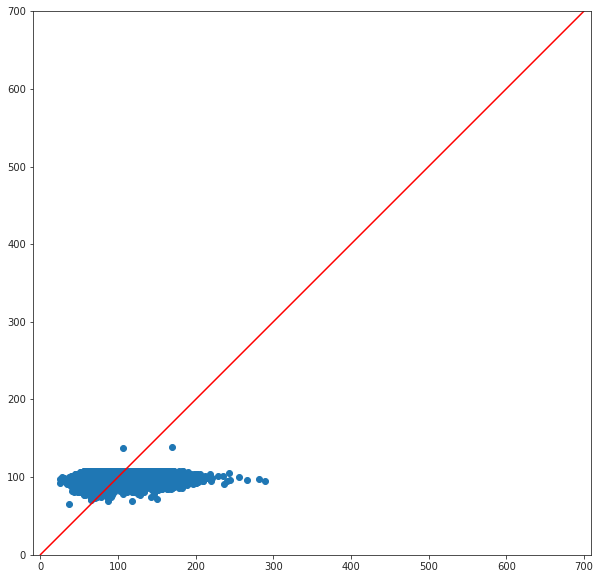

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(y.values, y_pred)
plt.plot([0,700], [0,700], color='red')
plt.axis('equal')
plt.xlim((0,700))
plt.ylim((0,700))
plt.show()